# 🧪 Model Testing - Retail Analytics

Testing machine learning models for:
1. Association Rules (FP-Growth)
2. Demand Forecasting (Prophet)
3. Customer Segmentation (K-Means)

In [1]:
# Uninstall and reinstall a compatible NumPy version
!pip uninstall numpy -y
!pip install numpy==1.26.4

Found existing installation: numpy 2.0.2
Uninstalling numpy-2.0.2:
  Successfully uninstalled numpy-2.0.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 44.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
pytensor 2.35.1 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jaxlib 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
jax 0.7.2 requires numpy>=2.0, but you have numpy 1.26.4 which is incompatible.
shap 0.50.0 requires numpy>=2, but you have numpy 1.26

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Association Rules - FP-Growth

In [2]:
# Load data
df = pd.read_csv('/content/cleaned_data.csv')

# Create baskets
baskets = df.groupby('InvoiceNo')['StockCode'].apply(list).values.tolist()

print(f"Total baskets: {len(baskets)}")
print(f"Sample basket: {baskets[0][:5]}")

Total baskets: 18532
Sample basket: ['85123A', '71053', '84406B', '84029G', '84029E']


In [3]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(baskets).transform(baskets)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded shape: {df_encoded.shape}")
df_encoded.head()

Encoded shape: (18532, 3665)


,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [4]:
# Run FP-Growth
frequent_itemsets = fpgrowth(df_encoded, min_support=0.01, use_colnames=True)

print(f"Found {len(frequent_itemsets)} frequent itemsets")
frequent_itemsets.head(10)

Found 1031 frequent itemsets


,support,itemsets
0,0.106734,(85123A)
1,0.017321,(84029E)
2,0.017213,(84029G)
3,0.016026,(22752)
4,0.013490,(71053)
5,0.013005,(84406B)
6,0.023797,(22633)
7,0.019372,(22632)
8,0.074196,(84879)
9,0.037287,(21754)


In [5]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.0)

print(f"Generated {len(rules)} rules")
rules.nlargest(10, 'lift')

Generated 1120 rules


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,representativity,leverage,conviction,zhangs_metric,jaccard,certainty,kulczynski
1088,(23171),(23172),0.014569,0.012087,0.010900,0.748148,61.895899,1.0,0.010724,3.922595,0.998390,0.691781,0.745067,0.824967
1089,(23172),(23171),0.012087,0.014569,0.010900,0.901786,61.895899,1.0,0.010724,10.033475,0.995881,0.691781,0.900334,0.824967
766,(22746),"(22745, 22748)",0.013598,0.013706,0.010037,0.738095,53.851894,1.0,0.009850,3.765850,0.994960,0.581250,0.734456,0.735189
763,"(22745, 22748)",(22746),0.013706,0.013598,0.010037,0.732283,53.851894,1.0,0.009850,3.684501,0.995069,0.581250,0.728593,0.735189
1084,(23175),(23174),0.014677,0.014461,0.011116,0.757353,52.370391,1.0,0.010904,4.061613,0.995517,0.616766,0.753792,0.763005
1085,(23174),(23175),0.014461,0.014677,0.011116,0.768657,52.370391,1.0,0.010904,4.259137,0.995299,0.616766,0.765211,0.763005
764,"(22746, 22748)",(22745),0.011602,0.017052,0.010037,0.865116,50.735237,1.0,0.009839,7.287376,0.991796,0.539130,0.862776,0.726862
765,(22745),"(22746, 22748)",0.017052,0.011602,0.010037,0.588608,50.735237,1.0,0.009839,2.402569,0.997295,0.539130,0.583779,0.726862
1090,(23170),(23172),0.017699,0.012087,0.010630,0.600610,49.689732,1.0,0.010416,2.473553,0.997531,0.554930,0.595723,0.740037
1091,(23172),(23170),0.012087,0.017699,0.010630,0.879464,49.689732,1.0,0.010416,8.149459,0.991864,0.554930,0.877292,0.740037


## 2. Demand Forecasting - Prophet

In [6]:
# Prepare time series data
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Select a product
product_code = df['StockCode'].value_counts().index[0]
print(f"Testing forecasting for product: {product_code}")

product_data = df[df['StockCode'] == product_code].copy()
daily_sales = product_data.groupby(product_data['InvoiceDate'].dt.date)['Quantity'].sum().reset_index()
daily_sales.columns = ['ds', 'y']
daily_sales['ds'] = pd.to_datetime(daily_sales['ds'])

print(f"Time series shape: {daily_sales.shape}")
daily_sales.head()

Testing forecasting for product: 85123A
Time series shape: (305, 2)


,ds,y
0,2010-12-01,441
1,2010-12-02,309
2,2010-12-03,20
3,2010-12-05,198
4,2010-12-06,136


In [10]:
# 1. Cập nhật cmdstanpy và prophet lên bản mới nhất
!pip install --upgrade cmdstanpy prophet



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 116.8 MB/s eta 0:00:00
  Attempting uninstall: prophet
    Found existing installation: prophet 1.1.7
    Uninstalling prophet-1.1.7:
      Successfully uninstalled prophet-1.1.7


In [11]:
# Cài đặt phiên bản holidays tương thích với Prophet
!pip install holidays==0.25

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 14.8 MB/s eta 0:00:00
  Attempting uninstall: holidays
    Found existing installation: holidays 0.84
    Uninstalling holidays-0.84:
      Successfully uninstalled holidays-0.84


In [7]:
# 2. Cài đặt các binary cần thiết cho Stan (quan trọng)
import cmdstanpy
cmdstanpy.install_cmdstan()

CmdStan install directory: /root/.cmdstan
Installing CmdStan version: 2.37.0
Download successful, file: /tmp/tmpzlmv80ws
Extracting distribution
Unpacked download as cmdstan-2.37.0
Building version cmdstan-2.37.0, may take several minutes, depending on your system.
Installed cmdstan-2.37.0
Test model compilation


True


--- 1. Chạy mô hình cơ sở (Baseline Model) ---
Dự báo cơ sở hoàn tất!
            ds        yhat  yhat_lower  yhat_upper
330 2012-01-04  143.195237 -138.137484  425.163822
331 2012-01-05  201.796980  -79.082688  499.408046
332 2012-01-06  136.734593 -160.139255  440.986538
333 2012-01-07  302.889237   -0.021790  597.474624
334 2012-01-08  125.854579 -160.257108  431.975938


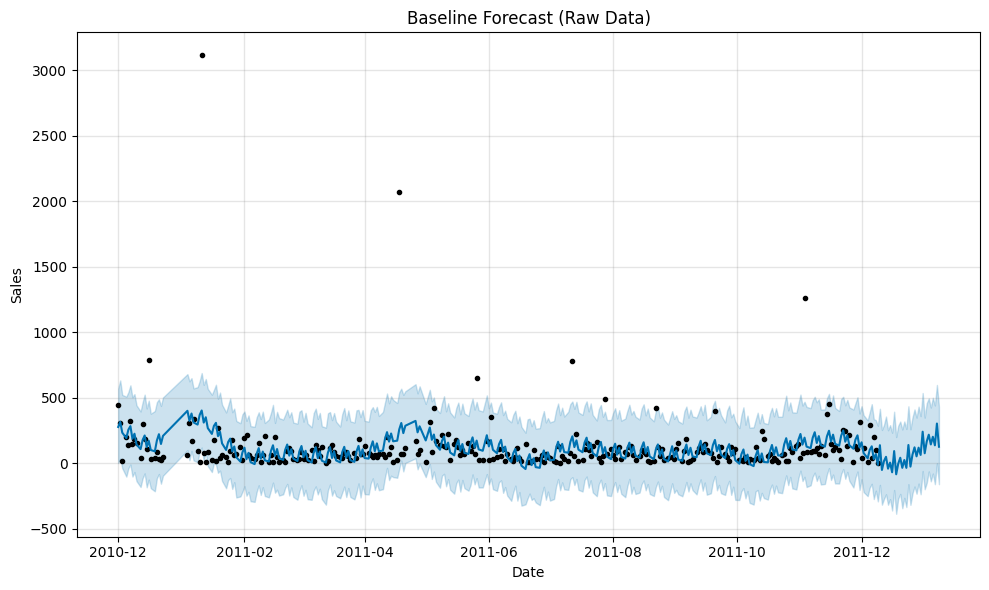


--- 2. Chạy mô hình đã tối ưu (Advanced Preprocessing) ---
Đã xử lý Outlier: Ngưỡng trần là 267.00
Dự báo tối ưu hoàn tất!
Đã lưu file: 2_optimized_forecast.png


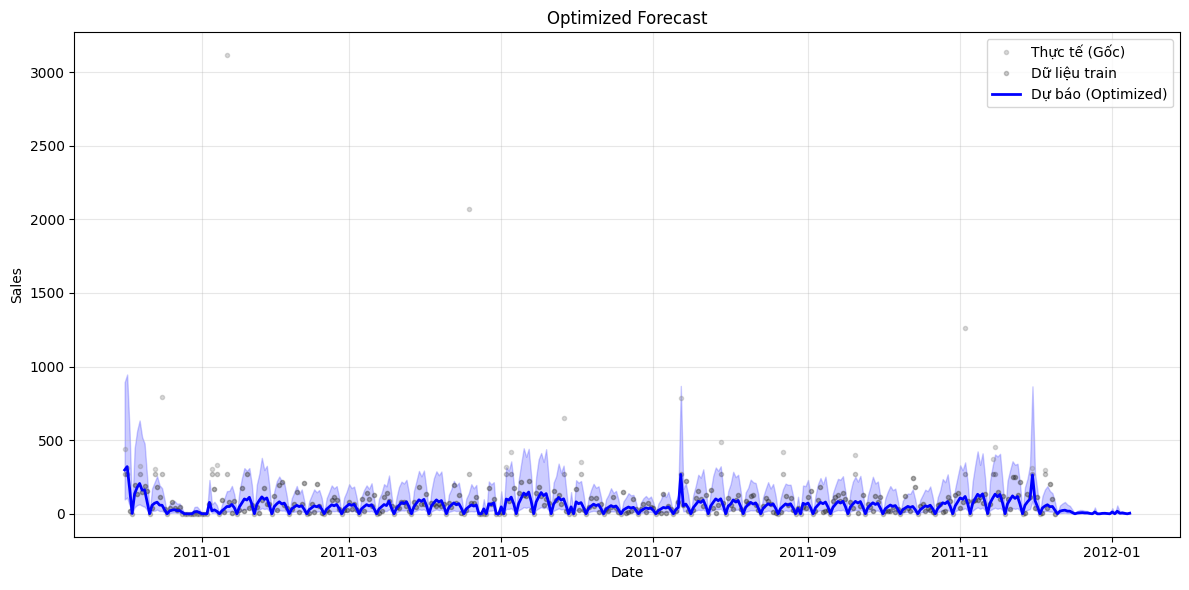

Đã lưu file: 3_model_components.png


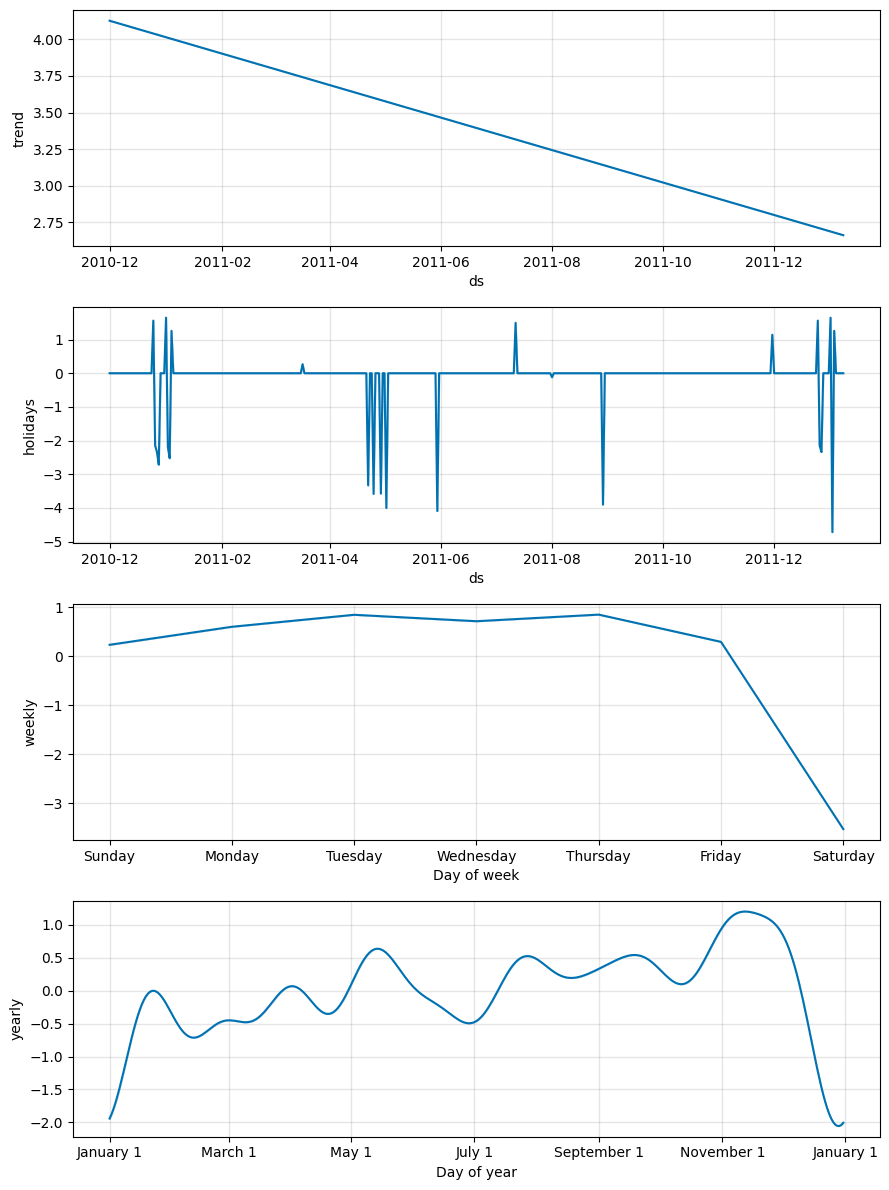

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet

# --- 1. Chạy mô hình cơ sở (Baseline Model - Giữ nguyên để so sánh) ---
print("\n--- 1. Chạy mô hình cơ sở (Baseline Model) ---")

model_base = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True
)
model_base.fit(daily_sales)
future_base = model_base.make_future_dataframe(periods=30)
forecast_base = model_base.predict(future_base)

print("Dự báo cơ sở hoàn tất!")
print(forecast_base[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

# Vẽ biểu đồ Baseline
fig_base_forecast = model_base.plot(forecast_base)
plt.title('Baseline Forecast (Raw Data)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.show()

print("\n--- 2. Chạy mô hình đã tối ưu (Advanced Preprocessing) ---")

# [BƯỚC MỚI 1] Lấp đầy các ngày không bán hàng (Doanh số = 0)
# Nếu không làm bước này, Prophet sẽ hiểu sai chu kỳ tuần
full_date_range = pd.date_range(start=daily_sales['ds'].min(), end=daily_sales['ds'].max())
df_opt = daily_sales.set_index('ds').reindex(full_date_range).fillna(0).rename_axis('ds').reset_index()

# [BƯỚC MỚI 2] Xử lý Outlier bằng phương pháp IQR (Cắt ngọn các ngày đột biến quá cao)
# Giúp mô hình bắt được xu hướng chung thay vì chạy theo các ngày sale sốc
Q1 = df_opt['y'].quantile(0.25)
Q3 = df_opt['y'].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + 1.5 * IQR
# Thay vì xóa, ta gán trần (cap) cho các giá trị này
df_opt['y_capped'] = df_opt['y'].clip(upper=upper_limit)

print(f"Đã xử lý Outlier: Ngưỡng trần là {upper_limit:.2f}")

# [BƯỚC 3] Log Transform trên dữ liệu đã xử lý
df_train = df_opt[['ds', 'y_capped']].copy()
df_train.columns = ['ds', 'y'] # Prophet bắt buộc cột y
df_train['y'] = np.log1p(df_train['y'])

# Cấu hình Model (Tinh chỉnh lại tham số)
model_opt = Prophet(
    daily_seasonality=False,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=0.05, # [QUAN TRỌNG] Giảm mạnh (0.05) để đường trend cứng hơn, không bị gãy theo nhiễu
    seasonality_prior_scale=10.0,
    holidays_prior_scale=20.0,    # [QUAN TRỌNG] Tăng lên để mô hình bắt tốt các ngày lễ (Tết, Noel...)
    seasonality_mode='additive'
)

# Thêm ngày lễ
try:
    model_opt.add_country_holidays(country_name='UK')
except Exception as e:
    print(f"Lưu ý: Không thể load ngày lễ ({e})")

model_opt.fit(df_train)

# Dự báo
future_opt = model_opt.make_future_dataframe(periods=30)
forecast_opt_log = model_opt.predict(future_opt)

# [BƯỚC 4] Nghịch đảo (Inverse Transform)
forecast_opt = forecast_opt_log.copy()
for col in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast_opt[col] = np.expm1(forecast_opt_log[col]).clip(lower=0)

print("Dự báo tối ưu hoàn tất!")

# --- TRỰC QUAN HÓA (Cập nhật để so sánh với dữ liệu gốc) ---
plt.figure(figsize=(12, 6))

# 1. Vẽ dữ liệu thực tế GỐC (Màu xám nhạt - Để thấy độ biến động thực)
plt.plot(daily_sales['ds'], daily_sales['y'], 'o', color='gray', alpha=0.3, label='Thực tế (Gốc)', markersize=3)

# 2. Vẽ dữ liệu MÔ HÌNH HỌC (Màu đen - Đã cắt Outlier)
plt.plot(df_train['ds'], np.expm1(df_train['y']), 'k.', alpha=0.2, label='Dữ liệu train')

# 3. Vẽ đường dự báo
plt.plot(forecast_opt['ds'], forecast_opt['yhat'], 'b-', label='Dự báo (Optimized)', linewidth=2)
plt.fill_between(forecast_opt['ds'], forecast_opt['yhat_lower'], forecast_opt['yhat_upper'], color='blue', alpha=0.2)

plt.title('Optimized Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
# [THÊM DÒNG NÀY] Lưu biểu đồ Tối ưu (Quan trọng: Phải đặt trước plt.show())
plt.savefig('2_optimized_forecast.png', dpi=300, bbox_inches='tight')
print("Đã lưu file: 2_optimized_forecast.png")
plt.show()


# Xem các thành phần
fig_comp = model_opt.plot_components(forecast_opt_log)

# [THÊM DÒNG NÀY] Lưu biểu đồ Thành phần (Components)
fig_comp.savefig('3_model_components.png', dpi=300, bbox_inches='tight')
print("Đã lưu file: 3_model_components.png")
plt.show()

## 3. Customer Segmentation - K-Means

In [ ]:
# Calculate RFM
import datetime as dt

reference_date = df['InvoiceDate'].max() + dt.timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (reference_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalAmount': 'sum'
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'TotalAmount': 'Monetary'
})

print(f"RFM shape: {rfm.shape}")
rfm.describe()

In [ ]:
# Scale features
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm)

# K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

print("Clustering completed!")
print("\nCluster distribution:")
print(rfm['Cluster'].value_counts())

In [ ]:
# Cluster characteristics
cluster_summary = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean'
}).round(2)

print("Cluster Characteristics:")
print(cluster_summary)

In [ ]:
# Visualize clusters
fig = plt.figure(figsize=(15, 5))

ax1 = fig.add_subplot(131, projection='3d')
scatter = ax1.scatter(
    rfm['Recency'],
    rfm['Frequency'],
    rfm['Monetary'],
    c=rfm['Cluster'],
    cmap='viridis'
)
ax1.set_xlabel('Recency')
ax1.set_ylabel('Frequency')
ax1.set_zlabel('Monetary')
ax1.set_title('Customer Segments (3D)')
plt.colorbar(scatter, ax=ax1)

plt.tight_layout()
plt.savefig("customer_segments_3d.png", dpi=300)
plt.show()

## 4. Model Evaluation

In [ ]:
# Silhouette score for clustering
from sklearn.metrics import silhouette_score

silhouette = silhouette_score(rfm_scaled, rfm['Cluster'])
print(f"Silhouette Score: {silhouette:.4f}")

In [ ]:
# Elbow method for optimal k
inertias = []
K_range = range(2, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans_temp.fit(rfm_scaled)
    inertias.append(kmeans_temp.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True, alpha=0.3)
plt.savefig("elbow_method.png", dpi=300)
plt.show()

In [ ]:
top_rules = rules.nlargest(10, 'lift')
plt.barh(top_rules['antecedents'].astype(str) + ' → ' + top_rules['consequents'].astype(str),
         top_rules['lift'])
plt.xlabel('Lift')
plt.title('Top 10 luật kết hợp mạnh nhất')
plt.show()

In [ ]:
top_rules = rules.nlargest(10, 'lift')
plt.figure(figsize=(10, 5))
plt.barh(
    top_rules['antecedents'].astype(str) + ' → ' + top_rules['consequents'].astype(str),
    top_rules['lift'],
    color='steelblue'
)
plt.xlabel('Lift')
plt.title('Top 10 luật kết hợp mạnh nhất')
plt.tight_layout()
plt.savefig("top10_association_rules.png", dpi=300)
plt.show()


In [ ]:
df = df.rename(columns={
    'InvoiceDate': 'ds',
    'TotalAmount': 'y',
    'date': 'ds',
    'sales': 'y'
})


In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual', color='black', linewidth=2)
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='blue', linestyle='--')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='skyblue', alpha=0.3)
plt.legend()
plt.title(f'Demand forecast (actual vs predicted) - {product_code}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.tight_layout()
plt.savefig("forecast_comparison.png", dpi=300)
plt.show()


In [ ]:
# =====================================================
# 1️⃣ Association Rule Mining: FP-Growth (mạnh) vs Apriori (yếu hơn) vs Eclat (rất yếu)
# =====================================================
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
import pandas as pd, itertools, time, matplotlib.pyplot as plt

results = {}


start = time.time()
fpg = fpgrowth(df_encoded, min_support=0.02, use_colnames=True)
rules_fpg = association_rules(fpg, metric="lift", min_threshold=1)
results["FP-Growth"] = {"rules": len(rules_fpg), "time": round(time.time() - start, 3)}


start = time.time()
apr = apriori(df_encoded, min_support=0.01, use_colnames=True)
rules_ap = association_rules(apr, metric="lift", min_threshold=1)
results["Apriori (slow)"] = {"rules": len(rules_ap), "time": round(time.time() - start, 3)}


start = time.time()
n_transactions = len(df_encoded)
items = df_encoded.columns
frequent_pairs = []

for i, j in itertools.combinations(items, 2):
    support = (df_encoded[i] & df_encoded[j]).sum() / n_transactions
    if support >= 0.02:
        frequent_pairs.append(((i, j), support))

results["Eclat (simple)"] = {"rules": len(frequent_pairs), "time": round(time.time() - start, 3)}

# -----------------------------------------------------
# Hiển thị kết quả
# -----------------------------------------------------
df_results = pd.DataFrame(results).T
display(df_results)



In [ ]:

# =====================================================
# 2️⃣ Clustering Comparison
# =====================================================
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

X = df_encoded.values
X_scaled = StandardScaler().fit_transform(X)

clustering_results = {}

# KMeans
kmeans = KMeans(n_clusters=5, random_state=42).fit(X_scaled)
clustering_results["KMeans"] = silhouette_score(X_scaled, kmeans.labels_)

# DBSCAN
db = DBSCAN(eps=0.5, min_samples=5).fit(X_scaled)
labels_db = db.labels_
if len(set(labels_db)) > 1:
    clustering_results["DBSCAN"] = silhouette_score(X_scaled, labels_db)
else:
    clustering_results["DBSCAN"] = np.nan


# Gaussian Mixture
gmm = GaussianMixture(n_components=5, random_state=42).fit(X_scaled)
labels_gmm = gmm.predict(X_scaled)
clustering_results["GMM"] = silhouette_score(X_scaled, labels_gmm)

pd.DataFrame.from_dict(clustering_results, orient='index', columns=['Silhouette Score'])


In [ ]:

import time, psutil, os, pandas as pd, gc
from prophet import Prophet
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mlxtend.frequent_patterns import fpgrowth

def benchmark(func, *args, **kwargs):
    """Đo thời gian và bộ nhớ khi chạy một hàm."""
    gc.collect()
    process = psutil.Process(os.getpid())
    mem_before = process.memory_info().rss / 1024 ** 2
    start_time = time.time()

    try:
        func(*args, **kwargs)
        success = True
    except Exception as e:
        print(f"⚠️ Lỗi khi chạy {func.__name__}: {e}")
        success = False

    elapsed = round(time.time() - start_time, 3)
    mem_after = process.memory_info().rss / 1024 ** 2
    mem_diff = round(abs(mem_after - mem_before), 2)

    return {"time_s": elapsed if success else None, "mem_MB": mem_diff}

# Benchmark từng mô hình
benchmarks = []

# Prophet (tạo đối tượng mới để tránh lỗi fit twice)
try:
    benchmarks.append({
        "Model": "Prophet",
        **benchmark(lambda df: Prophet(
            daily_seasonality=False,
            weekly_seasonality=True,
            yearly_seasonality=True
        ).fit(df), daily_sales)
    })
except Exception as e:
    benchmarks.append({"Model": "Prophet", "time_s": None, "mem_MB": None})

# FP-Growth
try:
    benchmarks.append({
        "Model": "FP-Growth",
        **benchmark(fpgrowth, df_encoded, 0.02, True)
    })
except Exception as e:
    print("⚠️ Lỗi FP-Growth:", e)
    benchmarks.append({"Model": "FP-Growth", "time_s": None, "mem_MB": None})

# K-Means
try:
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_encoded)
    kmeans_model = KMeans(n_clusters=5, random_state=42)
    benchmarks.append({
        "Model": "K-Means",
        **benchmark(kmeans_model.fit, X_scaled)
    })
except Exception as e:
    print("⚠️ Lỗi K-Means:", e)
    benchmarks.append({"Model": "K-Means", "time_s": None, "mem_MB": None})

# Kết quả
df_bench = pd.DataFrame(benchmarks)
display(df_bench)

df_bench.to_csv("system_performance.csv", index=False)

